# cleanup data and store for latter processing

To do:

- finish clean up ctd: 
    - mecanism to distinguish between underway and cast
    - ask confirmation that we don't have more to Benji
- [X] make movie ... but should add sea level
- [X]  go get wind data (arome)
- go get tide information (currents, sea level)
- process drifters1: get wind data, produce movies



In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# cognac data and tools
#import cognac.insitu as iu
import pynsitu as pin

In [2]:

# taos0-drifters0
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/drifters0"
yaml = "taos_drifters0.yaml"

# taos0-drifters1
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/drifters1"
yaml = "taos_drifters1.yaml"

cp = pin.campaign(os.path.join(root_dir,yaml))

0-4351896
0-4351908
0-4352049
0-4351904
0-4352175
0-4352044
ctd_parceque
ctd_hydrophone
ship_hydrophone
ship_parceque


---

## drifters

`drifters_bin.csv` is a binary csv file and it was converted into an ascii csv file with:

```
cat drifters_bin.csv | tr -d '\0' > drifters.csv
```



In [16]:
def read_drifters(file):
    
    df = pd.read_csv(file, parse_dates=[1])
    df["DeviceDateTime"]
    
    df = (df
          .rename(columns=dict(DeviceName="id", DeviceDateTime="time", 
                               Latitude="latitude", Longitude="longitude"))
          .sort_values("id")
         )
    #df["id"] = df["id"].map(lambda v: v.replace("-",""))
    df = df.set_index("id")
        
    return df

In [17]:
drifter_file = os.path.join(cp.pathr, "drifters.csv")
df = read_drifters(drifter_file)
df.head()

time BatteryStatus     CommId  GPS Confidence  \
id                                                                       
0-4351896 2022-05-18 06:17:21          GOOD  0-4351896               0   
0-4351896 2022-05-18 15:37:21          GOOD  0-4351896               0   
0-4351896 2022-05-17 23:12:20          GOOD  0-4351896               0   
0-4351896 2022-05-17 14:22:23          GOOD  0-4351896               0   
0-4351896 2022-05-19 03:37:24          GOOD  0-4351896               0   

           GPS Fail Counter  GpsQuality   latitude  longitude  
id                                                             
0-4351896                 0           3  49.413167  -0.389650  
0-4351896                 0           3  49.381120  -0.319612  
0-4351896                 0           3  49.368052  -0.244832  
0-4351896                 0           3  49.362044  -0.305364  
0-4351896                 0           3  49.380347  -0.279851

### compute and show typical time intervals

This is to decide on a reasonable target timeline.
A 2 minutes sampling rate seems reasonable.

<AxesSubplot:ylabel='Frequency'>

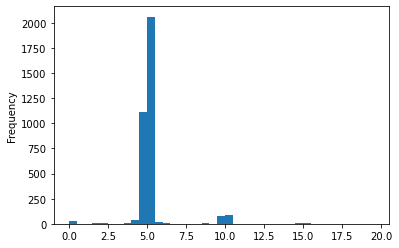

In [18]:
dt = df.groupby(df.index).apply(lambda df: df.sort_values("time")["time"].diff()/pd.Timedelta("1m")).droplevel(0)
dt.plot.hist(bins=np.arange(0,20,0.5))

### filter data, compute velocities

In [24]:
def _resample(df):
    df = df.sort_values("time").set_index("time")
    df = df.geo.resample("10T") #, interpolate=True
    # interpolate
    df = df.geo.resample("10T", interpolate=True) 
    # add velocity
    df = df.geo.compute_velocities()
    return df.reset_index("time")

dfi = df.groupby("id").apply(_resample).droplevel(1)

### extract drifter ids and test if both ids sources are identical

In [25]:
ids = list(df.index.unique())
ids_cp = [u for u in cp if  "0-435" in u]
set(ids) == set(ids_cp)

True

In [26]:
i = ids_cp[5]
print(i)
dfi.loc[i].geo.plot_bokeh(unit=cp[i])

0-4352044


Loading BokehJS ...

### trim data and concatenate back

The output below is used to adjust the campaign yaml file

In [27]:
D = []
for i in ids:
    _df = dfi.loc[i].set_index("time")
    for d in cp[i]:
        print("----")
        _dft = _df.geo.trim(d)
        _dft.loc[:, "deployment"] = d.label
        _dft.loc[:, "id"] = i
        start = _dft.iloc[0][["longitude", "latitude"]]
        end = _dft.iloc[-1][["longitude", "latitude"]]
        print(i, d.label, f"start = {start.name}  {start.longitude:.4f}  {start.latitude:.4f}", )
        print(i, d.label, f"end = {end.name}  {end.longitude:.4f}  {end.latitude:.4f}", )
        D.append(_dft)

dfit = pd.concat(D, axis=0).reset_index().set_index("id")
dfit.head()

----
0-4351896 d0 start = 2022-05-17 09:30:00  -0.2489  49.3413
0-4351896 d0 end = 2022-05-19 11:10:00  -0.2407  49.3701
----
0-4351904 d0 start = 2022-05-17 09:20:00  -0.2443  49.3396
0-4351904 d0 end = 2022-05-19 10:50:00  -0.2611  49.3869
----
0-4351908 d0 start = 2022-05-17 08:30:00  -0.2465  49.3392
0-4351908 d0 end = 2022-05-19 10:20:00  -0.2768  49.3979
----
0-4352044 d0 start = 2022-05-17 09:00:00  -0.2583  49.3343
0-4352044 d0 end = 2022-05-19 11:40:00  -0.2748  49.3466
----
0-4352049 d0 start = 2022-05-17 09:40:00  -0.2242  49.3422
0-4352049 d0 end = 2022-05-19 11:00:00  -0.2417  49.3822
----
0-4352175 d0 start = 2022-05-17 09:10:00  -0.2471  49.3403
0-4352175 d0 end = 2022-05-19 10:50:00  -0.2645  49.3936


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


time  GPS Confidence  GPS Fail Counter  GpsQuality  \
id                                                                            
0-4351896 2022-05-17 09:30:00             0.5               0.0         3.0   
0-4351896 2022-05-17 09:40:00             0.0               0.0         3.0   
0-4351896 2022-05-17 09:50:00             0.0               0.0         3.0   
0-4351896 2022-05-17 10:00:00             0.0               0.0         3.0   
0-4351896 2022-05-17 10:10:00             0.0               0.0         3.0   

            latitude  longitude            x            y         u         v  \
id                                                                              
0-4351896  49.341256  -0.248911  4030.812388 -4360.252572  0.358765 -0.192611   
0-4351896  49.340644  -0.247291  4148.627162 -4428.173468  0.196358 -0.113201   
0-4351896  49.339818  -0.245371  4288.228855 -4519.986483  0.232669 -0.153022   
0-4351896  49.339040  -0.243697  4409.952989 -4606.360736  0.202874 -0.143957   
0-4351896  49.338327  -0.242152  4522.299972 -4685.622146  0.187245 -0.132102   

           velocity deployment  
id                              
0-4351896  0.407199         d0  
0-4351896  0.226652         d0  
0-4351896  0.278479         d0  
0-4351896  0.248760         d0  
0-4351896  0.229154         d0

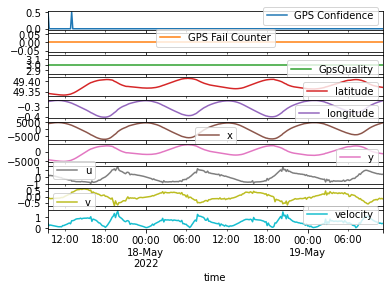

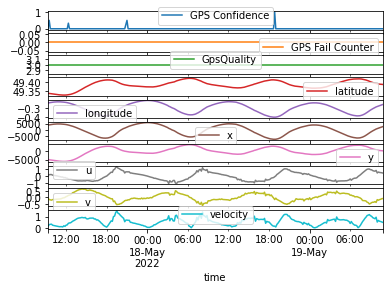

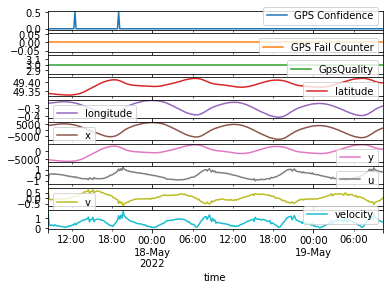

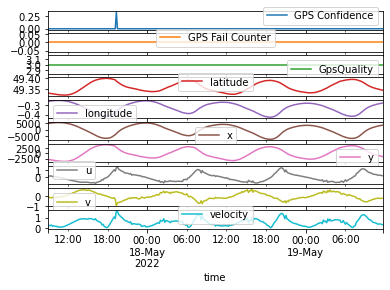

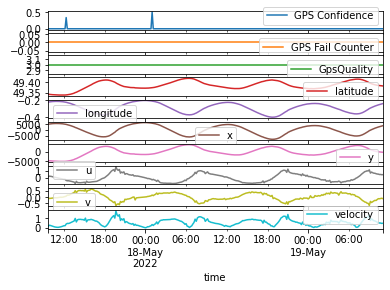

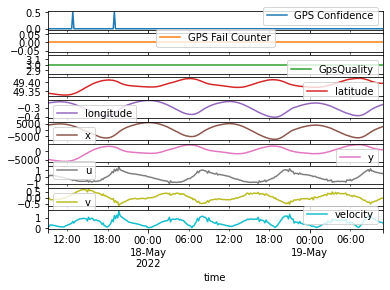

In [28]:
for i in ids:
    dfit.loc[i].set_index("time").plot(subplots=True) #x="longitude", y="latitude"

### overview map of the trajectories

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


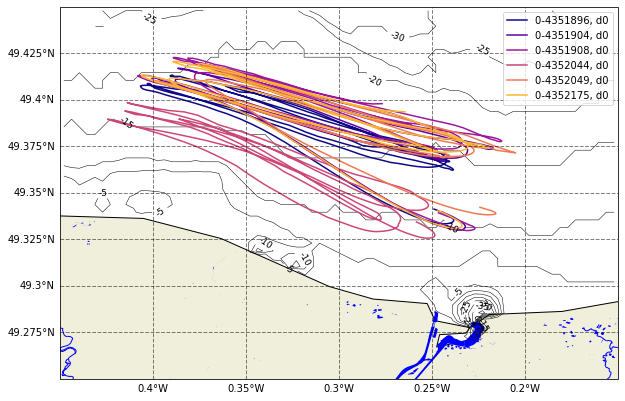

In [33]:
_df = dfit.reset_index().set_index(["id", "deployment"])

#bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-.3, .0, 49.25, 49.4] # taos0-drifters0
bounds=[-.45, -.15, 49.25, 49.45] # taos0-drifters1
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

keys = _df.groupby(_df.index).groups.keys()
colors = pin.get_cmap_colors(len(keys))

for k, c in zip(keys, colors):
    _dfk = _df.groupby(_df.index).get_group(k).reset_index()
    ax.plot(_dfk.longitude, _dfk.latitude, color=c, transform=crs, label=", ".join(k))

ax.legend()

In [35]:
# store
dfit.to_xarray().to_netcdf(os.path.join(cp.pathp, 'drifters.nc'), mode="w")

---

## ctd, underway, cast

Very convenient the GPS logging !

**taos0 - drifters0**

- First day, the first ctd deployment (d0) is noisy for salinity with fluctuations with period of less that 10s. Do we see this for other deployments? We apply a median filter for now
- Second day: salinity is less noisy

**taos0 - drifters1**

- First day - hydrophone: 
    - no gps position during half of first cast: ctd turned on too late?
    - takes about 45s for the conductivity to reach equilibrium, several downcast did not wait long enough
   
Keep only downcast (because slower than upcast) for CTD profiless


In [3]:
def read_sonde_lern(file, tz_offset=0, stype=0):
    """ Load LERN CTD data
    """
    
    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())

    # replace NUL, strip whitespace from the end of the strings, split each string into a list
    d = [v.replace('\x00', '').strip().replace(",",".").split('\t') for v in d]

    # remove some empty rows
    d = [v for v in d if len(v) > 1]
    
    #d[0]:
    #['Date', 'Time', 'Site', 'Unit ID', 'User ID',
    # '°C-19K104425', 'mmHg-19C102825', 'DO %-20A103151', 'DO mg/L-20A103151', 
    # 'C-mS/cm-19K104425', 'SAL-PSU-19K104425', 'FNU-19M102353',
    # 'Chl RFU-19M101982', 'Chl ug/L-19M101982',
    # 'DEP m-19K105267']

    # benji deployments
    # ['Date', 'Time', 'Site', 'Unit ID', 'User ID', 
    # '°C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 
    # 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 
    # 'DEP m-20H100561']

    if stype==0:
        columns = ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
         'temperature', 'air_pressure', 'DO_p', 'DO_mgL', 
         'conductivity', 'salinity', 'FNU',
         'Chl_RFU', 'Chl_ugL',
         'depth', 'latitude', 'longitude']
    elif stype==1:
        columns = ['Date', 'Time', 'Site', 'Unit ID', 'User ID',
         'temperature', 'air_pressure', 'DO_p', 'DO_mgL', 
         'conductivity', 'salinity',
         'depth', 'latitude', 'longitude']

    df = pd.DataFrame(d[1:], columns=columns)
    
    # convert column 0 and 1 to a datetime
    df['time'] = pd.to_datetime(df["Date"] + ' ' + df["Time"]) + pd.Timedelta("1H")*tz_offset

    df.set_index("time", inplace=True)
    df = df.drop(columns=["Date", "Time", "Site", "Unit ID", "User ID"])

    df = df.astype('float')

    # convert air pressure from mmHg to bar
    df["air_pressure"] = df["air_pressure"]/750.06

    return df

**Parceque**

In [18]:
u, stype = "ctd_parceque", 0 # franck - check

case=2
if case==0:
    # taos0-drifters0, day 0
    ctd_path = os.path.join(cp.pathr, u+"_11052022.csv")
    labels = [f"u{i}" for i in range(4)]
elif case==1:
    # taos0-drifters0, day 1  !!!! not cleaned ?
    ctd_path = os.path.join(cp.pathr, u+"_13052022.csv")
    labels = [f"u{i}" for i in range(4,7)]
elif case==2:
    # taos0-drifters1, day 0
    ctd_path = os.path.join(cp.pathr, u+"_17052022.csv")
    labels = ["u0"]
elif case==3:
    # taos0-drifters1, day 1
    ctd_path = os.path.join(cp.pathr, u+"_19052022.csv")
    labels = ["u1"]

**Hydrophone**

In [41]:
u, stype = "ctd_hydrophone", 1 # benji

case=2
if case==0:
    # taos0-drifters0, day 0  !!! no valid CTD
    pass
elif case==1:
    # taos0-drifters0, day 1  !!! no valid CTD
    pass
elif case==2:
    # taos0-drifters1, day 0
    ctd_path = os.path.join(cp.pathr, u+"_17052022.csv")
    labels = [f"c0_{i}" for i in range(15)]
elif case==3:
    # taos0-drifters1, day 1
    ctd_path = os.path.join(cp.pathr, u+"_19052022.csv")
    labels = [f"c1_{i}" for i in range(9)]

In [42]:
df = read_sonde_lern(ctd_path, tz_offset=-2, stype=stype)

df.sw.plot_bokeh(unit=cp[u])

Loading BokehJS ...

# trim, filter and store

In [43]:
D = {}
for d in cp[u]:
    if (isinstance(labels, str) and labels=="all") or d.label in labels:
        # trim first to exclude irrelevant values
        _df = df.sw.trim(d)
        if d.label[0]=="u":
            # underway data
            print(d, "underway processing")
            _df = _df.sw.resample("20s", op="median")
        elif d.label[0]=="c":
            print(d, "cast processing")
            _df = _df.sw.compute_vertical_profile(1.)
        D[d.label] = _df
    else:
        print(f"skipping {d.label}")

c0_0 / start 2022-05-17 07:31:00 -0.24 49.34 / end 2022-05-17 07:37:40 -0.24 49.34 cast processing

c0_1 / start 2022-05-17 07:44:40 -0.26 49.33 / end 2022-05-17 07:50:50 -0.26 49.33 cast processing

c0_2 / start 2022-05-17 08:00:26 -0.25 49.34 / end 2022-05-17 08:03:06 -0.25 49.34 cast processing

c0_3 / start 2022-05-17 08:05:00 -0.25 49.34 / end 2022-05-17 08:10:40 -0.25 49.34 cast processing

c0_4 / start 2022-05-17 08:14:38 -0.25 49.34 / end 2022-05-17 08:18:16 -0.25 49.34 cast processing

c0_5 / start 2022-05-17 08:24:33 -0.23 49.34 / end 2022-05-17 08:27:47 -0.23 49.34 cast processing

c0_6 / start 2022-05-17 08:51:26 -0.24 49.32 / end 2022-05-17 08:53:25 -0.24 49.32 cast processing

c0_7 / start 2022-05-17 08:56:57 -0.24 49.32 / end 2022-05-17 08:59:46 -0.24 49.32 cast processing

c0_8 / start 2022-05-17 09:03:17 -0.24 49.31 / end 2022-05-17 09:06:00 -0.24 49.31 cast processing

c0_9 / start 2022-05-17 09:08:39 -0.25 49.31 / end 2022-05-17 09:11:24 -0.25 49.31 cast processing



/Users/aponte/Code/pynsitu/pynsitu/seawater.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SA'] = gsw.SA_from_SP(s, p, self._lon, self._lat)
/Users/aponte/Code/pynsitu/pynsitu/seawater.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CT'] = gsw.CT_from_t(df.SA, t, p)
/Users/aponte/Code/pynsitu/pynsitu/seawater.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

### store

In [44]:
for d, _df in D.items():
    _df.to_xarray().to_netcdf(os.path.join(cp.pathp, f'{u}_{d}.nc'), mode="w")

### various plots

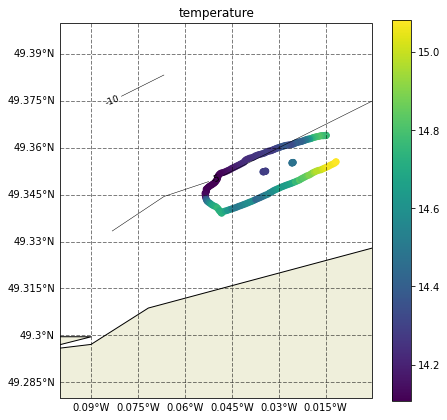

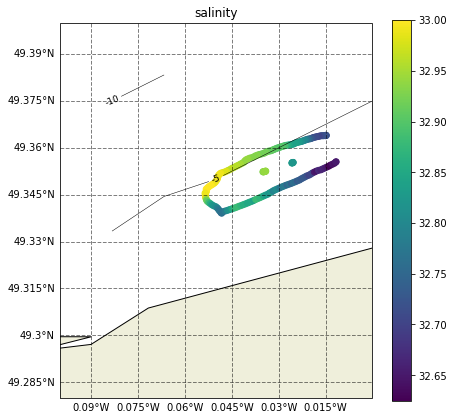

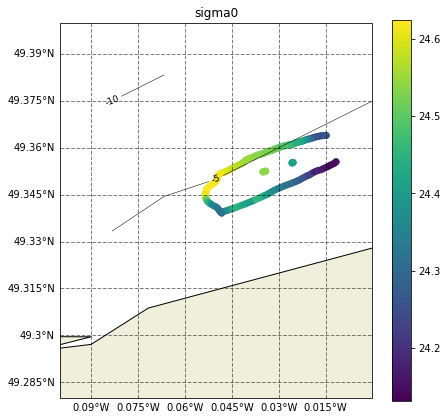

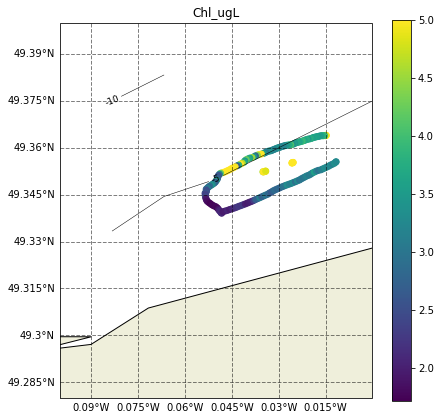

In [15]:
bounds = [-.3, -.2, 49.28, 49.4] # drifters0 - first day
bounds = [-.1, 0., 49.28, 49.4] # drifters0 - second day

def scatter(v, **kwargs):
    """ produce scatter plot """
    # compute global bounds
    vmin, vmax = _global_bounds(v)
    dkwargs = dict(vmin=vmin, vmax=vmax)
    dkwargs.update(**kwargs)
    
    fig, ax, crs = cp.plot_map(bounds=bounds, 
                               coast="bseine", land=None,
                               #coast="bseine", land=None, rivers="bseine",
                               figsize=(7,7),
                              )
    for d, _df in D.items():
        #_df = _df.sw.resample("10s")
        im = ax.scatter(_df.longitude, _df.latitude, c=_df[v],
                        transform=crs, label=v,
                        **dkwargs
                       )
    ax.set_title(v)
    cbar = fig.colorbar(im)
    cbar.formatter.set_useOffset(False)
    
def _global_bounds(v):
    _min = min([_df[v].min() for d, _df in D.items()])
    _max = max([_df[v].max() for d, _df in D.items()])
    return _min, _max
    
cbar = scatter("temperature") # vmin=13.8, vmax=14.1
cbar = scatter("salinity")
cbar = scatter("sigma0")
cbar = scatter("Chl_ugL", vmax=5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


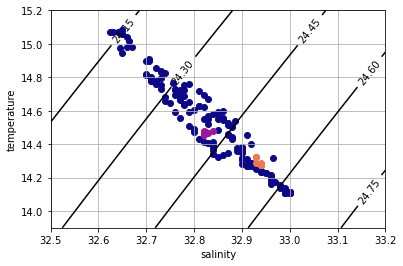

In [13]:
slim, tlim = (32.5, 33.2), (13.6, 14.4) # drifters0 - day 1
slim, tlim = (32.5, 33.2), (13.9, 15.2) # drifters0 - day 2

fig, ax = pin.plot_ts(slim, tlim)
colors = pin.get_cmap_colors(len(D))
for d, c in zip(D, colors):
    _df = D[d]
    ax.scatter(_df.salinity, _df.temperature, c=c)

array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'pressure'}>,
        <AxesSubplot:title={'center':'DO_p'}>,
        <AxesSubplot:title={'center':'DO_mgL'}>],
       [<AxesSubplot:title={'center':'conductivity'}>,
        <AxesSubplot:title={'center':'salinity'}>,
        <AxesSubplot:title={'center':'FNU'}>,
        <AxesSubplot:title={'center':'Chl_RFU'}>],
       [<AxesSubplot:title={'center':'Chl_ugL'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>],
       [<AxesSubplot:title={'center':'SA'}>,
        <AxesSubplot:title={'center':'CT'}>,
        <AxesSubplot:title={'center':'sigma0'}>, <AxesSubplot:>]],
      dtype=object)

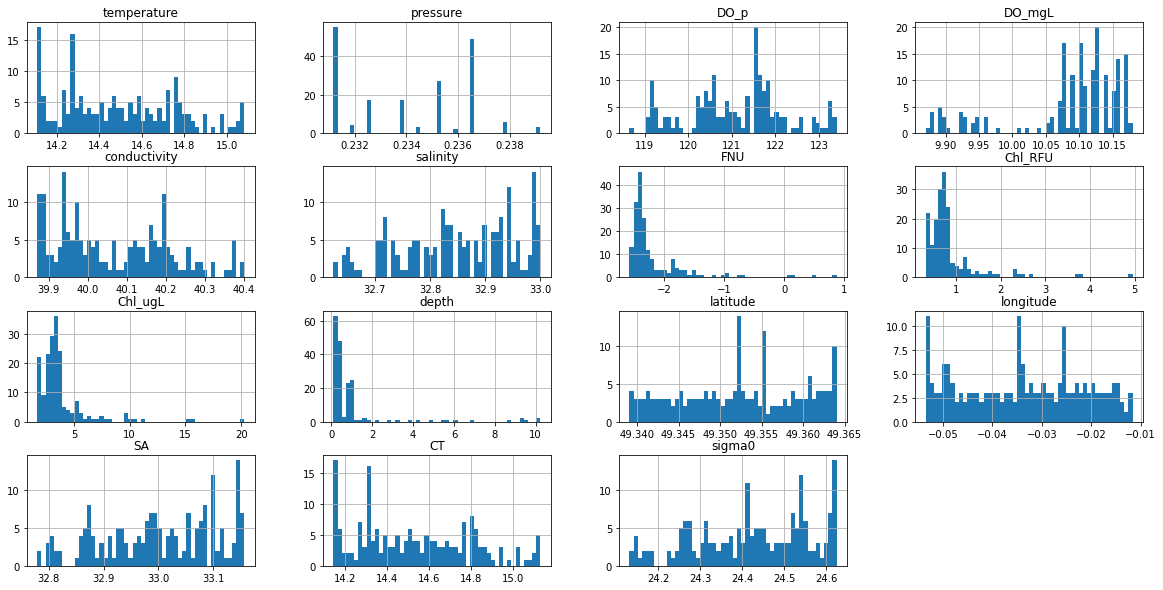

In [14]:
# concatenate data back and show histograms
df = pd.concat([df for d, df in D.items()], axis=0)
df.hist(bins=50, figsize=(20,10))

### CTD cast

In [51]:
def plot_profiles(D, v, offset):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    colors = pin.get_cmap_colors(len(D))

    i=0
    for d, df in D.items():
        off = offset*i
        ax.plot(df[v]+off, df.index, color=colors[i], lw=3)
        #ax.axvline(off)
        i+=1

    ax.grid()
    ax.set_title(v)

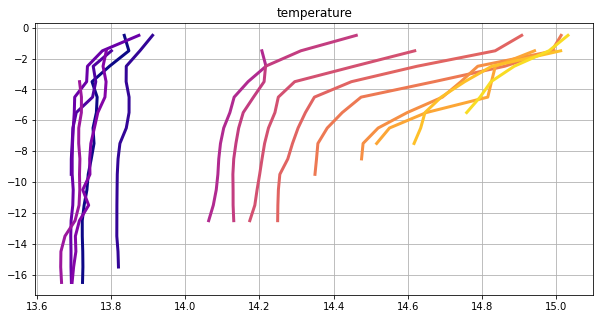

In [56]:
plot_profiles(D, "temperature", 0.)

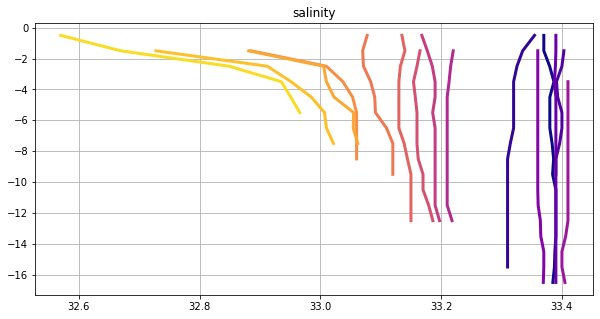

In [55]:
plot_profiles(D, "salinity", 0.)

---

## ships


**taos0-drifters1:** Missing data files for second day

In [26]:
def load_ship(file, correct_day=None):
    """ load ship (hydrophone, parceque) data
    
    Parameters
    ----------
    file: str
        path to data file
    correct_day: tuple, optional
        fix day of first data point (year, month, day)
    """
    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())

    # replace NUL, strip whitespace from the end of the strings, split each string into a list
    d = [v.replace('\n', '').split(',') for v in d]

    columns = d[0]
    #print(columns)
    # ['ID', 'trksegID', 'lat', 'lon', 'ele', 'time', 'magvar', 'geoidheight', 'name', 'cmt', 'desc', 'src', 'sym', 'type', 'fix', 'sat', 'hdop', 'vdop', 'pdop', 'ageofdgpsdata', 'dgpsid', 'Temperature', 'Depth', 'wtemp', 'hr', 'cad', '']

    df = pd.DataFrame(d[1:], columns=columns)
    df["time"] = pd.to_datetime(df["time"])

    # fix day
    if correct_day:
        if isinstance(correct_day, dict):
            day = pd.Timestamp(**correct_day, tz="UTC")
        else:
            # assumes Timestamp
            day = correct_day
        t0 = df["time"][0]
        dt = day - t0.round("1D")
        print(f"Fix first time from {t0} to {t0 + dt}")
        df["time"] = (df["time"] + dt).dt.tz_localize(None) # drop timezone as well (xarray complications down the line)

    # only keep non zero columns
    selected_columns = ["time", "lon", "lat", "Depth", "Temperature"]
    df = (df[selected_columns]
          .set_index("time")
          .replace("","0")
          .astype('float')
    )
    
    # rename critical columns
    df = df.rename(columns=dict(lon="longitude", lat="latitude", Depth="water_depth", Temperature="air_temperature"))
    
    return df

In [32]:
deployments = [d.label for d in list(cp['ship_hydrophone'])]

d = deployments[0] # d0
#d = deployments[1] # d1
print(f"deployment {d}")

file_p = os.path.join(cp.pathr, cp['ship_parceque'][d].info["file"])
file_h = os.path.join(cp.pathr, cp['ship_hydrophone'][d].info["file"])

cday = dict(year=2022, month=5, day=11)
cday = cp['ship_parceque'][d].start.time.round("1D").tz_localize("UTC")

df_p = load_ship(file_p, correct_day=cday)
df_h = df = load_ship(file_h, correct_day=cday)

deployment d0
Fix first time from 2002-10-01 07:17:39+00:00 to 2022-05-17 07:17:39+00:00
Fix first time from 2002-10-01 07:33:15+00:00 to 2022-05-17 07:33:15+00:00


### store

In [33]:
for df, label in zip([df_h, df_p], ["hydrophone", "parceque"]):
    (df.to_xarray()
     .to_netcdf(os.path.join(cp.pathp, f'ship_{label}_{d}.nc'), mode="w")
    )

### plot

In [34]:
df_h.geo.plot_bokeh(unit=cp["ship_hydrophone"])
df_h.geo.plot_bokeh_map()

Loading BokehJS ...

Loading BokehJS ...

In [35]:
df_p.geo.plot_bokeh(unit=cp["ship_parceque"])
df_p.geo.plot_bokeh_map()

Loading BokehJS ...

Loading BokehJS ...

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


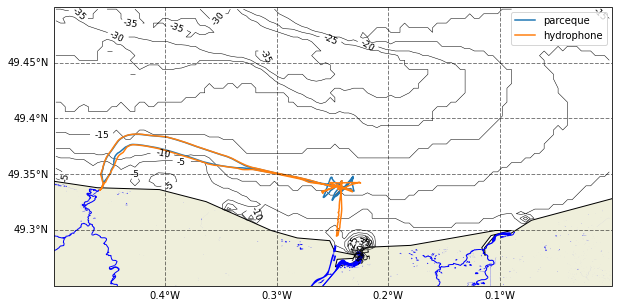

In [36]:
bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-.5, .0, 49.25, 49.5]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

ax.plot(df_p.longitude, df_p.latitude, transform=crs, label="parceque")
ax.plot(df_h.longitude, df_h.latitude, transform=crs, label="hydrophone")

ax.legend()

Inspect typical time interval between ship positions.

Typically around 10 seconds

Text(0.5, 1.0, 'Time interval between positions in seconds')

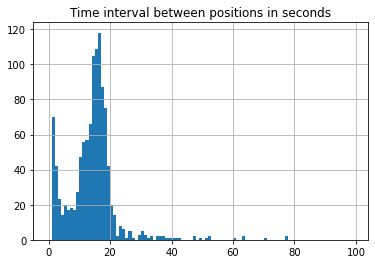

In [37]:
_df = df_p.reset_index()
_df["dt"] = _df["time"].diff()/pd.Timedelta("1s")
_df["dt"].hist(bins=np.arange(0,100,1))
plt.title("Time interval between positions in seconds")

---

## observed and modelled sea level and tidal currents

In [ ]:
import taos.utils as ut
dsh = ut.predict_tides(_ds.date_start, real=False, summed=False)

----

## wind, arome

To be done on datarmor.
Copy extracted netcdf file back on laptop.


In [8]:
import xarray as xr
import pandas as pd
from glob import glob

In [51]:
arome_dir = "/home/ref-oc-intranet-restricted/modeles_mf/arome_v2/best_estimate/"


def load_arome(t, dt=None, freq="1H", rkwargs={}, **kwargs):
    """ Extract ERA data
    https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5
    
    Parameters
    ----------
    t: date-like object
        date for extraction
    dt: tuple, optional
        time interval in days around t
    freq: str
        frequency of outputs selected, e.g. "1H" or "1D"
    rkwargs: dict
        passed to load_dataset
    **kwargs: passed for direct selection
    """
    
    t = pd.to_datetime(t)
    if dt is not None:
        t = [t+pd.Timedelta(days=_dt) for _dt in range(*dt)]
        t = pd.date_range(t[0],t[-1], freq=freq)
    else:
        t = [t]
    
    #
    D = []
    for _t in t:
        _rpath = f"{_t.year}/METEOFRANCE_AROME_{_t.year}{_t.month:02d}{_t.day:02d}T{_t.hour:02d}Z*.nc"
        files = glob(os.path.join(arome_dir, _rpath)) 
        _ds = xr.merge([xr.load_dataset(f, **rkwargs).squeeze().sel(**kwargs) for f in files])
        D.append(_ds)
    ds = xr.concat(D, dim="time")

    return ds

In [52]:
t = pd.Timestamp(2022,5,12)
ds = load_arome(t, dt=(-30,5,), longitude=slice(-2,2), latitude=slice(48,50)).chunk(dict(time="auto"))

nc = os.path.join(os.getenv("SCRATCH"), "taos0_drifters0_arome.nc")
ds.to_netcdf(nc, mode="w")

In [54]:
nc = os.path.join(os.getenv("SCRATCH"), "taos0_drifters0_arome.nc")
ds.to_netcdf(nc, mode="w")

### quick overview

In [5]:
ds = cp.load("arome.nc")

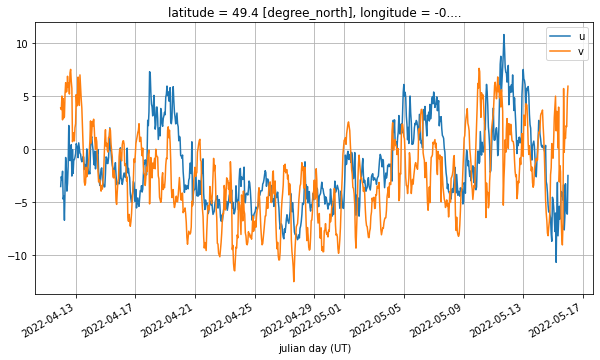

In [13]:
_ds = ds.sel(longitude=-0.2, latitude=49.4, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(10,5))
_ds.u10m.plot(label="u")
_ds.v10m.plot(label="v")
ax.grid()
ax.set_ylabel("")
ax.legend()

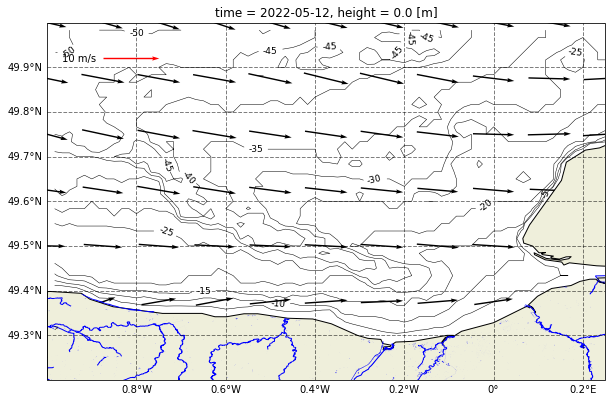

In [42]:
bounds=[-.5, -.1, 49.25, 49.5]
bounds=[-1., .25, 49.2, 50.]
fig, ax, crs = cp.plot_map(bounds=bounds, coast="bseine", land=None, rivers="bseine")

di=5
_ds = (ds.sel(time="2022-05-12 00:00:00")
       .isel(longitude=slice(0,None,di),latitude=slice(0,None,di))
      )

q = _ds.plot.quiver(x="longitude", y="latitude", u="u10m", v="v10m", scale=1e2, transform=crs, zorder=-2)
qk = ax.quiverkey(q, 0.1, 0.9, 10, '10 m/s', transform=crs, color="r",
                  labelpos='W', coordinates='axes', zorder=10)

---

## old stuff

In [25]:
file = "sonde_benji_13.csv"
file_path = os.path.join(root_dir, file)
df = read_sonde_lern(file_path, stype=1)

['Date', 'Time', 'Site', 'Unit ID', 'User ID', 'ï¿½C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 'DEP m-20H100561']


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

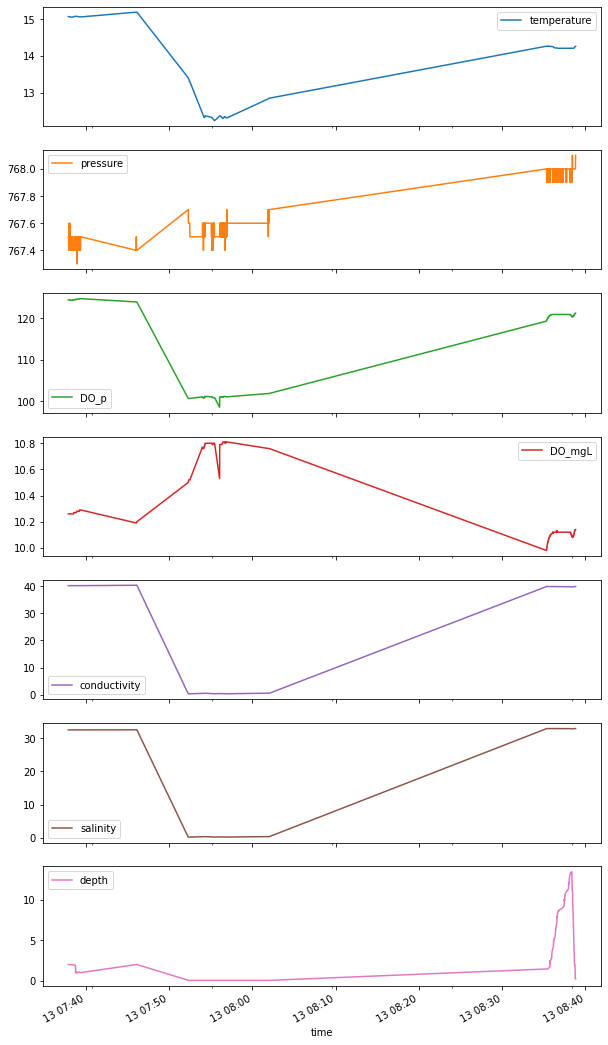

In [26]:
df.plot(subplots=True, figsize=(10,20))